In [0]:
import torchvision
import tensorflow as tf

In [0]:
#%cd /content/
#!/usr/bin/python
# essential imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


import imageio
import cv2
import os
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion() 
import numpy as np
import timeit
import pandas as pd
import re
import math
import copy
import pickle
#tensorflow 1.15
import tensorflow as tf
#print(tf.__version__)
import torch
from sklearn.model_selection import train_test_split

# default seeding for reproducability
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(24)

In [0]:
# Import torch Libraries
import torch
from torch import optim, nn
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

from torch.nn import Linear, ReLU, CrossEntropyLoss, MSELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
#from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
#adam sgd combined optimizer
!pip install adabound
import adabound
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import copy

#defaults
PIXEL_LENGTH_MODIFIED = 128
FEATURE_SIZE_MODIFIED = PIXEL_LENGTH_MODIFIED*PIXEL_LENGTH_MODIFIED
PIXEL_LENGTH_MNIST = 28
FEATURE_SIZE_MNIST = PIXEL_LENGTH_MNIST*PIXEL_LENGTH_MNIST

## helpers

In [0]:
# training/testing functions
def train(epoch, train_loader, model, error, optimizer, batch_size):
    model.train()
    running_loss = 0.0
    #loss_total = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        #peak at tensor details
        # if batch_idx==1:
        #   # visualize one of the images in data set
        #   plt.imshow(np.squeeze(images[0].numpy()), cmap='Greys')
        #   plt.axis("off")
        #   plt.title(str(labels[0].numpy()))
        #   #plt.savefig('graph.png')
        #   plt.show()
        #reshape for training
        train = images.view(batch_size,3,32,32).to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        #print(loss)
        #loss_total += loss.item()

        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        #print every 100 batches
        running_loss += loss.item()
        if batch_idx % 100 == 0 and batch_idx != 0:
            # plt.imshow(images[0].numpy().reshape(128,128))
            # plt.axis('off')#########################################################################################
            # plt.show()
            #Print Loss
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), running_loss/100))
            running_loss = 0.0
    #loss_total /= len(train_loader)
    #print('Test set: Test loss: {:.4f}'.format(loss_total))
    #return last loss
    return loss.item()

def test(test_loader, model, error, batch_size):
    # Validation
    with torch.no_grad():
        model.eval()
        # Calculate Accuracy         
        correct = 0
        loss_test = 0.0
        # Iterate through test dataset
        for batch_idx, (images, labels) in enumerate(test_loader):
            # if batch_idx==1:
            #   # visualize one of the images in data set
            #   plt.imshow(np.squeeze(images[0].numpy()), cmap='Greys')
            #   plt.axis("off")
            #   plt.title(str(labels[0].numpy()))
            #   #plt.savefig('graph.png')
            #   plt.show()

            test = images.view(batch_size,3,32,32).to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)
            # Forward propagation
            outputs = model(test)
            

            # sum up batch loss
            loss_test += error(outputs, labels).item()
            # get the index of the max log-probability
            predicted = outputs.max(1, keepdim=True)[1]
            # if batch_idx==1:
            #   print(predicted[0].item())
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        loss_test /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        print('\nTest set: Test loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(loss_test, correct, len(test_loader.dataset), accuracy))
        #return loss and accuracy
        return loss_test, accuracy
        

In [0]:
batch_size = 50
workers = os.cpu_count()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

lengths = [5000, 5000]

fullset_train = torchvision.datasets.CIFAR10(root='./data', download=True, train=True,
                                       transform=transform)

fullset_test = torchvision.datasets.CIFAR10(root='./data', download=True, train=False,
                                       transform=transform)

testset, finaltestset = torch.utils.data.random_split(fullset_test, lengths)

train_loader = torch.utils.data.DataLoader(fullset_train, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

final_test_loader = torch.utils.data.DataLoader(finaltestset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

#check for gpu/cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 95080851.94it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
fullset_test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
train_loader.dataset.data.shape

(50000, 32, 32, 3)

## squeeze dat net

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
       
        
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)
        
        
    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_1(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
#optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
#load trained dictionary
#PATH = '/content/squeezenet_loss.pth'
#model.load_state_dict(torch.load(PATH))

In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 100
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.324690
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.280486
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.248495
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.187538
Train Epoch: 0 [25000/50000 (50%)]	Train Loss: 2.157347
Train Epoch: 0 [30000/50000 (60%)]	Train Loss: 2.101729
Train Epoch: 0 [35000/50000 (70%)]	Train Loss: 2.104143
Train Epoch: 0 [40000/50000 (80%)]	Train Loss: 2.041676
Train Epoch: 0 [45000/50000 (90%)]	Train Loss: 2.028886

Test set: Test loss: 2.0140, Accuracy: 1365/5000 (27%)

Better accuracy at Epoch 0: accuracy = 27.3%
Better loss at Epoch 0: loss = 2.0140409195423126%

Train Epoch 1: lr = 0.1
Train Epoch: 1 [5000/50000 (10%)]	Train Loss: 2.009719
Train Epoch: 1 [10000/50000 (20%)]	Train Loss: 1.970154
Train Epoch: 1 [15000/50000 (30%)]	Train Loss: 1.942461
Train Epoch: 1 [20000/50000 (40%)]	Train Loss: 1.952287
Train Epoch: 1 [25000/50000 (50%)]	Train Loss: 1.940961
Train Epoch: 1 

KeyboardInterrupt: ignored

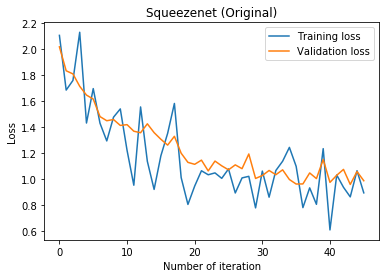

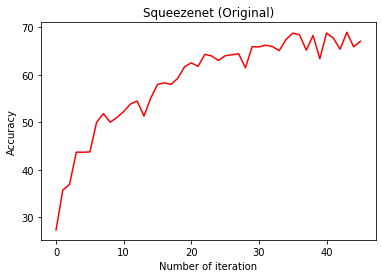

Mean time per epoch 24.28885762584782 seconds
Best accuracy: 68.98  Best training loss: 0.6064860820770264  Best validation loss: 0.9561693543195724


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))

### testing adding layers

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']

model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        #self.squeeze_activation = nn.ReLU(inplace=True)
        self.squeeze_activation = nn.Tanh(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        #self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand1x1_activation = nn.Tanh(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        #self.expand3x3_activation = nn.ReLU(inplace=True)
        self.expand3x3_activation = nn.Tanh(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, version='1_0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)


def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_0', pretrained, progress, **kwargs)


def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _squeezenet('1_1', pretrained, progress, **kwargs)

## squeezing 1.1

In [0]:

#change the line below for different models

# import torchvision.models as models
# model = models.squeezenet1_0(pretrained=True)

model = squeezenet1_1(num_classes=10)

# print(model)

model = model.to(device=device, dtype=torch.float)

# Cross Entropy Loss 
error = CrossEntropyLoss().to(device=device, dtype=torch.float)

#Optimizer
learning_rate = 0.1
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=learning_rate)

#Optimizer adam
# learning_rate = 0.04
# optimizer = Adam(model.parameters(), lr=learning_rate)
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, dampening=0, weight_decay=0.0002, nesterov=False)
# optimizer = SGD(model.parameters(), lr=learning_rate)

#adaptive learning rate
# how many epoc before decreasing learning rate
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [0]:
%%time
#training/testing
loss_list = []
loss_list_test = []
iteration_list = []
accuracy_list = []
# execution time checking
execution_time = []

PATH = '/content/squeezenet_acc.pth'
best_model_wts = copy.deepcopy(model.state_dict())
PATH2 = '/content/squeezenet_loss.pth'
best_model_loss = copy.deepcopy(model.state_dict())

#PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
#latest_model_wts = copy.deepcopy(model.state_dict())
best_loss = float("inf")
best_acc = 0.0
#set number of epochs 
num_epochs = 25
for epoch in range(num_epochs):
    #print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))
    print("\nTrain Epoch {}: lr = {}".format(epoch,learning_rate))

    start = timeit.default_timer()
    loss_list.append(train(epoch, train_loader, model, error, optimizer, batch_size))
    loss_test, accuracy = test(test_loader, model, error, batch_size)
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)

    loss_list_test.append(loss_test)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)
    #exp_lr_scheduler.step()

    #saving model with best acc 
    if accuracy > best_acc:
      print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, PATH)
    #saving model with best loss
    if loss_test < best_loss:
      print(f"Better loss at Epoch {epoch}: loss = {loss_test}%")
      best_loss = loss_test
      best_model_loss = copy.deepcopy(model.state_dict())
      torch.save(best_model_loss, PATH2)
#load model
# model = Net()
# model.load_state_dict(torch.load(PATH))


Train Epoch 0: lr = 0.1
Train Epoch: 0 [5000/50000 (10%)]	Train Loss: 2.325610
Train Epoch: 0 [10000/50000 (20%)]	Train Loss: 2.302584
Train Epoch: 0 [15000/50000 (30%)]	Train Loss: 2.302584
Train Epoch: 0 [20000/50000 (40%)]	Train Loss: 2.302584


KeyboardInterrupt: ignored

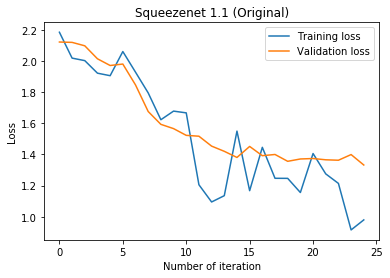

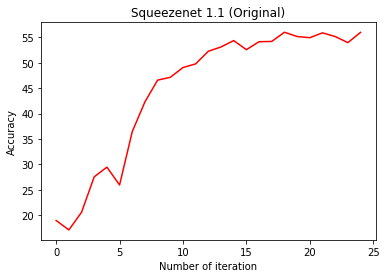

Mean time per epoch 24.102241231279994 seconds
Best accuracy: 56.0  Best training loss: 0.915762186050415  Best validation loss: 1.3321439516544342


In [0]:
  # visualization loss 
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Squeezenet 1.1 (Original)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Squeezenet 1.1 (Original)")
plt.show()

print(f"Mean time per epoch {np.mean(execution_time)} seconds") # returns time in sec 
print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


In [0]:
print(str(iteration_list))
print(str(loss_list))
print(str(loss_list_test))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[2.1838796138763428, 2.0178678035736084, 2.0018107891082764, 1.9213051795959473, 1.9051405191421509, 2.060081958770752, 1.9278173446655273, 1.7947484254837036, 1.6226844787597656, 1.6778972148895264, 1.66666841506958, 1.2055578231811523, 1.095021367073059, 1.1353867053985596, 1.5495797395706177, 1.1674708127975464, 1.4456303119659424, 1.2469276189804077, 1.2465100288391113, 1.155672550201416, 1.4057934284210205, 1.2752779722213745, 1.2141385078430176, 0.915762186050415, 0.9800704121589661]
[2.121135513782501, 2.118862378001213, 2.0969004899263384, 2.013542518019676, 1.9705626732110977, 1.9798394191265105, 1.845936484336853, 1.675332503914833, 1.5929853576421737, 1.5656340289115906, 1.522431623339653, 1.5168981689214707, 1.4533483976125716, 1.4200146025419236, 1.3806409525871277, 1.4513233157992362, 1.391934596300125, 1.3997139877080917, 1.3558638465404511, 1.3708526888489723, 1.3737952956557273, 

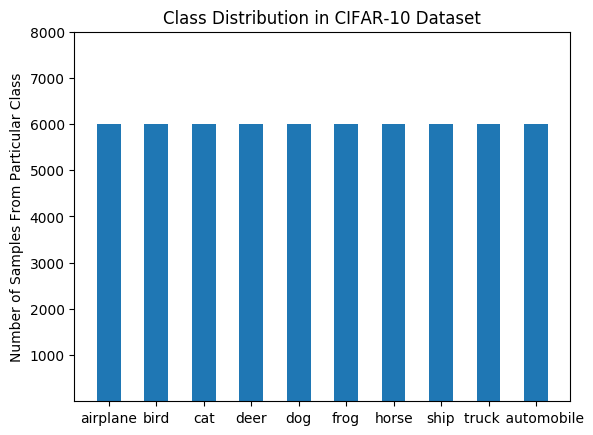

<Figure size 1200x1200 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('airplane','bird', 'cat', 'deer',	'dog', 'frog', 'horse', 'ship',	'truck   ','    automobile')
y_pos = np.arange(len(objects))
y = [1000, 2000, 3000,4000,5000, 6000,7000, 8000]
performance = [6000,6000,6000,6000,6000,6000,6000,6000,6000, 6000]

plt.bar(y_pos, performance, width=0.5)
plt.xticks(y_pos, objects)
plt.yticks(y)
plt.ylabel('Number of Samples From Particular Class')
plt.title('Class Distribution in CIFAR-10 Dataset')
from matplotlib.pyplot import figure
figure(num=None, figsize=(15,15), dpi=80, facecolor='w', edgecolor='k')
plt.show()